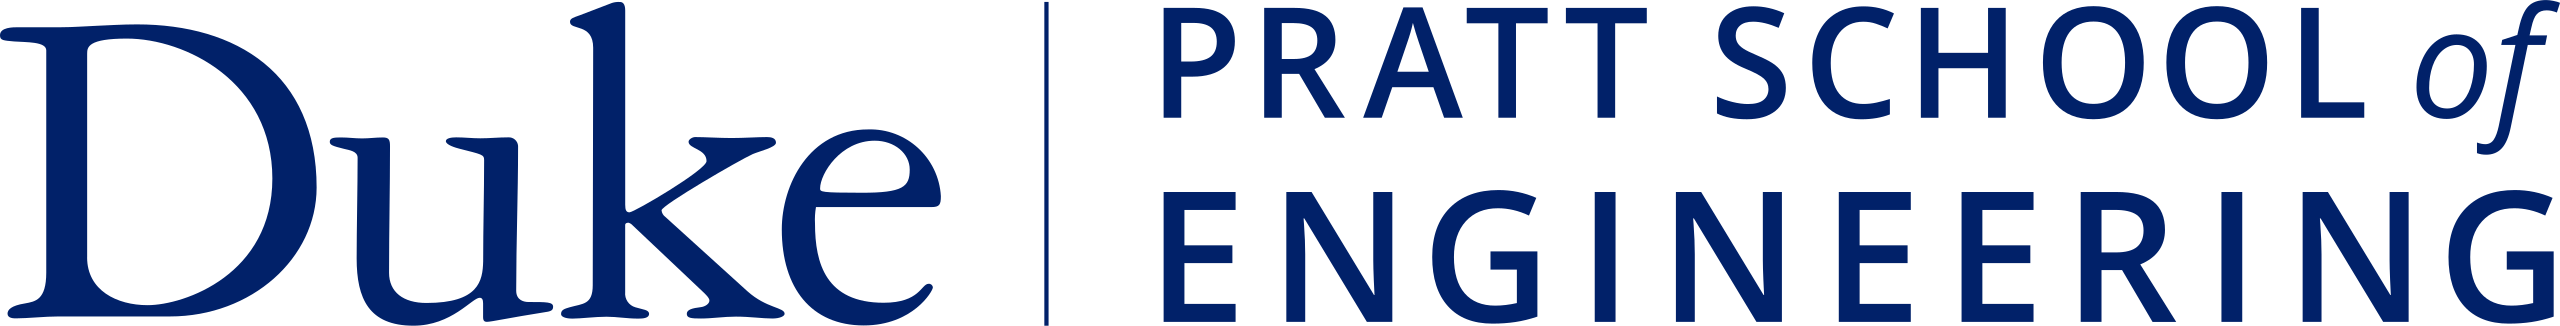
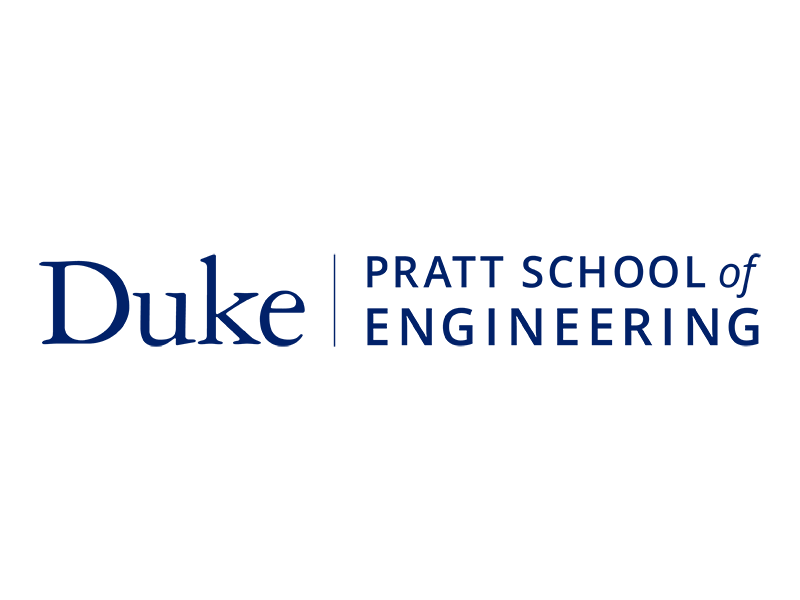

# FINTECH 545 Quantitative Risk Management
## Project 2

### Keese Phillips

[![Open In Collab](https://colab.research.google.com/A/colab-badge.svg)](https://colab.research.google.com/github/keesephillips/quantitative_risk_management/blob/main/Project02/notebook.ipynb)

In [27]:
# import os

# # Remove Colab default sample_data
# !rm -r ./sample_data

# # Clone GitHub files to colab workspace
# repo_name = "quantitative_risk_management"
# git_path = 'https://github.com/keesephillips/quantitative_risk_management'
# !git clone "{git_path}"

# notebook_dir = 'Project02'

# # Install dependencies from requirements.txt file
# !pip install -r "{os.path.join(repo_name,notebook_dir,'requirements.txt')}"

# # Change working directory to location of notebook
# path_to_notebook = os.path.join(repo_name,notebook_dir)
# %cd "{path_to_notebook}"
# %ls

## Problem 1 <a class="anchor" id="p1"></a>

In [28]:
import numpy as np
import pandas as pd

data = pd.read_csv('data/DailyPrices.csv')
cols = ['Date','SPY','AAPL','EQIX']
data = data[cols]

data.head()

,Date,SPY,AAPL,EQIX
0,2023-01-03,370.367920,123.768456,639.647766
1,2023-01-04,373.227142,125.045052,656.679016
2,2023-01-05,368.967438,123.718987,637.822998
3,2023-01-06,377.428589,128.271118,650.683350
4,2023-01-09,377.214661,128.795578,657.654114


### A

In [29]:
def return_calculate(prices, method="ARITHMETIC", dateColumn="Date", remove_mean=False):
    if dateColumn not in prices.columns:
        raise ValueError(f"dateColumn '{dateColumn}' not found in DataFrame columns.")
    
    dates = prices[dateColumn].iloc[1:].reset_index(drop=True)
    
    price_columns = [col for col in prices.columns if col != dateColumn]
    current_prices = prices[price_columns]
    
    p_ratio = current_prices.shift(-1).iloc[:-1, :] / current_prices.iloc[:-1, :].values
    
    if method.upper() == "ARITHMETIC":
        returns = p_ratio - 1
    elif method.upper() == "LOG":
        returns = np.log(p_ratio)
        
    for col in returns.columns:
        if remove_mean:
            mean = returns[col].mean()
            returns[col] -= mean
    
    out = pd.DataFrame({dateColumn: dates})
    for col in price_columns:
        out[col] = returns[col].values
    
    std_deviations = returns.iloc[:,:].std()
    
    return out, std_deviations

arithmetic_returns, arithmetic_std_deviations = return_calculate(data, method="ARITHMETIC", dateColumn="Date", remove_mean=True)    

In [30]:
print(arithmetic_std_deviations)
arithmetic_returns.tail()

SPY     0.008077
AAPL    0.013483
EQIX    0.015361
dtype: float64


,Date,SPY,AAPL,EQIX
498,2024-12-27,-0.011492,-0.014678,-0.006966
499,2024-12-30,-0.012377,-0.014699,-0.008064
500,2024-12-31,-0.004603,-0.008493,0.006512
501,2025-01-02,-0.003422,-0.027671,0.000497
502,2025-01-03,0.011538,-0.003445,0.015745


### B

In [31]:
log_returns, log_std_deviations = return_calculate(data, method="LOG", dateColumn="Date", remove_mean=True)

In [32]:
print(log_std_deviations)
log_returns.tail()

SPY     0.008078
AAPL    0.013446
EQIX    0.015270
dtype: float64


,Date,SPY,AAPL,EQIX
498,2024-12-27,-0.011515,-0.014675,-0.006867
499,2024-12-30,-0.012410,-0.014696,-0.007972
500,2024-12-31,-0.004577,-0.008427,0.006602
501,2025-01-02,-0.003392,-0.027930,0.000613
502,2025-01-03,0.011494,-0.003356,0.015725


## Problem 2 <a class="anchor" id="p2"></a>

In [33]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
from scipy.integrate import quad
from scipy.stats import t, norm, spearmanr, multivariate_normal


data = pd.read_csv("data/DailyPrices.csv", parse_dates=['Date'])
cols = ['Date','SPY','AAPL','EQIX']
data = data[cols]
data.tail()

,Date,SPY,AAPL,EQIX
499,2024-12-27,595.010010,255.589996,942.659973
500,2024-12-30,588.219971,252.199997,935.929993
501,2024-12-31,586.080017,250.419998,942.890015
502,2025-01-02,584.640015,243.850006,944.229980
503,2025-01-03,591.950012,243.360001,959.969971


### A

In [34]:
returns, _ = return_calculate(data, method="ARITHMETIC", dateColumn="Date", remove_mean=True)    
current_prices = data.iloc[-1]

holdings = {
    'SPY':100, 
    'AAPL':200,
    'EQIX':150
}

A = list(holdings.keys())
current_prices = current_prices[A]
returns = returns[A]

PV = 0.0
for asset in A:
    value = holdings[asset] * current_prices[asset]
    PV += value

print(f"Current Portfolio Value: {PV:.2f}")


Current Portfolio Value: 251862.50


### B

#### a

In [9]:
def populate_weights(n, lambda_val):
    exponents = np.arange(n)
    raw_weights = (1 - lambda_val) * (lambda_val ** exponents)
    cum_weights = np.sum(raw_weights)
    if cum_weights != 0:
        weights = raw_weights / cum_weights
    else:
        weights = np.ones(n) / n
    return weights, cum_weights

def exponentially_weighted_covariance(data, lambda_val=0.97):
    n_vars = data.shape[1]
    n_obs = data.shape[0]
    ew_cov = np.zeros((n_vars, n_vars))
    
    weights, _ = populate_weights(n_obs, lambda_val)
    weights = weights[::-1]  
    
    for x in range(n_vars):
        for y in range(n_vars):
            cov = 0.0
            for i in range(n_obs):
                cov += weights[i] * data.iloc[i, x] * data.iloc[i, y]
            ew_cov[x, y] = cov
    
    return ew_cov

def VaR_array(a, alpha=0.05):
    x = np.sort(a)
    nup = int(np.ceil(len(a) * alpha))
    ndn = int(np.floor(len(a) * alpha))
    v = 0.5 * (x[nup-1] + x[ndn-1]) 
    
    return -v

def ES_array(a, alpha=0.05):
    x = np.sort(a)
    nup = int(np.ceil(len(a) * alpha))
    ndn = int(np.floor(len(a) * alpha))
    v = 0.5 * (x[nup-1] + x[ndn-1])  
    
    es = np.mean(x[x <= v])
    return -es

def VaR_dist(d, alpha=0.05):
    return -d.ppf(alpha)

def ES_dist(d, alpha=0.05):
    v = VaR_dist(d, alpha=alpha)
    
    def f(x):
        return x * d.pdf(x)
    
    st = d.ppf(1e-12)
    result, _ = quad(f, st, -v)
    
    return -result / alpha

cov_matrix = exponentially_weighted_covariance(returns, lambda_val=0.97)
weights = np.array([holdings[stock] * current_prices[stock] / PV for stock in holdings.keys()])

portfolio_std_dev = np.sqrt(weights @ cov_matrix @ weights.T)

alpha = 0.05

risk_metrics_normal = {}
for i, stock in enumerate(holdings.keys()):
    std_dev_stock = np.sqrt(cov_matrix[i, i])
    
    stock_dist = stats.norm(0, std_dev_stock)
    
    var_stock = VaR_dist(stock_dist, alpha=alpha) * holdings[stock] * current_prices[stock]
    es_stock = ES_dist(stock_dist, alpha=alpha) * holdings[stock] * current_prices[stock]
    
    risk_metrics_normal[stock] = {"VaR": var_stock, "ES": es_stock}

portfolio_dist = stats.norm(0, portfolio_std_dev)

var_portfolio = VaR_dist(portfolio_dist, alpha=alpha) * PV
es_portfolio = ES_dist(portfolio_dist, alpha=alpha) * PV

risk_metrics_normal["Portfolio"] = {"VaR": var_portfolio, "ES": es_portfolio}

print("Part B.a")
for key, val in risk_metrics_normal.items():
    print(f"{key}: VaR = {val['VaR']:.2f}, ES = {val['ES']:.2f}")

Part B.a
SPY: VaR = 827.85, ES = 1038.16
AAPL: VaR = 946.08, ES = 1186.42
EQIX: VaR = 2933.51, ES = 3678.74
Portfolio: VaR = 3856.32, ES = 4835.98


#### b

In [10]:
fitted_params = {}
for stock in holdings.keys():
    data = returns[stock].values
    df_val, loc_val, scale_val = t.fit(data, floc=0)
    fitted_params[stock] = (df_val, scale_val)

U = pd.DataFrame({
    stock: t.cdf(returns[stock].values, fitted_params[stock][0], loc=0, scale=fitted_params[stock][1])
    for stock in holdings.keys()
})

R = U.rank(pct=True).corr()

NSim = 1000000
mean_vec = np.zeros(len(holdings))
corr_matrix = R.values
sim_norm = multivariate_normal.rvs(mean=mean_vec, cov=corr_matrix, size=NSim)

U_sim = norm.cdf(sim_norm)

simulated_returns = {}
for i, stock in enumerate(holdings.keys()):
    df_val, scale_val = fitted_params[stock]
    simulated_returns[stock] = t.ppf(U_sim[:, i], df_val, loc=0, scale=scale_val)

pnl_sim = {}
for stock in holdings.keys():
    pnl_sim[stock] = holdings[stock] * current_prices[stock] * simulated_returns[stock]

portfolio_pnl_sim = np.zeros(NSim)
for stock in holdings.keys():
    portfolio_pnl_sim += pnl_sim[stock]

risk_metrics_copula = {}
for stock in holdings.keys():
    var = VaR_array(pnl_sim[stock], alpha=0.05)
    es = ES_array(pnl_sim[stock], alpha=0.05)
    risk_metrics_copula[stock] = (var, es)

var_portfolio = VaR_array(portfolio_pnl_sim, alpha=0.05)
es_portfolio = ES_array(portfolio_pnl_sim, alpha=0.05)
risk_metrics_copula["Portfolio"] = (var_portfolio, es_portfolio)

print("Part B.b")
for key, val in risk_metrics_copula.items():
    print(f"{key}: VaR = {val[0]:.2f}, ES = {val[1]:.2f}")

Part B.b
SPY: VaR = 775.20, ES = 1036.30
AAPL: VaR = 1032.19, ES = 1469.24
EQIX: VaR = 3400.29, ES = 4887.77
Portfolio: VaR = 4407.74, ES = 6140.67


#### c

In [11]:
historical_pnl = {}
for stock in holdings.keys():
    hist_return = returns[stock].values
    historical_pnl[stock] = holdings[stock] * current_prices[stock] * hist_return

portfolio_historical_pnl = np.sum([historical_pnl[stock] for stock in holdings.keys()], axis=0)

risk_metrics_hist = {}
for stock in holdings.keys():
    var = VaR_array(historical_pnl[stock], alpha=0.05)
    es = ES_array(historical_pnl[stock], alpha=0.05)
    risk_metrics_hist[stock] = (var, es)

var_portfolio = VaR_array(portfolio_historical_pnl, alpha=0.05)
es_portfolio = ES_array(portfolio_historical_pnl, alpha=0.05)
risk_metrics_hist["Portfolio"] = (var_portfolio, es_portfolio)

print("Part B.c")
for key, val in risk_metrics_hist.items():
    print(f"{key}: VaR = {val[0]:.2f}, ES = {val[1]:.2f}")

Part B.c
SPY: VaR = 873.32, ES = 1088.41
AAPL: VaR = 1082.07, ES = 1452.52
EQIX: VaR = 3672.82, ES = 4757.45
Portfolio: VaR = 4580.03, ES = 6118.67


## Problem 3

In [12]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import newton
import matplotlib.pyplot as plt

S = 31       # Stock price
X = 30       # Strike price
T = 0.25     # Time to maturity (years)
r = 0.10     # Risk-free rate
C = 3.00     # Call price
b = r        # Cost of carry (no dividend)

### A

In [13]:
def gbsm(call, S, X, T, r, b, sigma):
    d1 = (np.log(S/X) + (b + sigma**2/2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if call:
        return S * np.exp((b-r)*T) * stats.norm.cdf(d1) - X * np.exp(-r*T) * stats.norm.cdf(d2)
    else:
        return X * np.exp(-r*T) * stats.norm.cdf(-d2) - S * np.exp((b-r)*T) * stats.norm.cdf(-d1)

def implied_vol_objective(sigma):
    return gbsm(True, S, X, T, r, b, sigma) - C

implied_vol = newton(implied_vol_objective, 0.3)
print(f"Implied Volatility: {implied_vol:.6f} or {implied_vol*100:.2f}%")

Implied Volatility: 0.335080 or 33.51%


### B

In [14]:
def delta_call(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

def delta_put(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1) - 1
    return delta

def vega_call(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return vega

def vega_put(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return vega

def theta_call(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    theta = (- (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
             - r * X * np.exp(-r * T) * norm.cdf(d2))
    return theta

def theta_put(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    theta = (- (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
             + r * X * np.exp(-r * T) * norm.cdf(-d2))
    return theta



delta = delta_call(S, X, T, r, implied_vol)
vega = vega_call(S, X, T, r, implied_vol)
theta = theta_call(S, X, T, r, implied_vol)

print(f"Delta: {delta:.4f}")
print(f"Vega: {vega:.4f}")
print(f"Theta: {theta:.4f}\n")

volatility_increase = 0.01
estimated_price_change_vega = vega * volatility_increase

print(f"∆ Price (Vega): ${estimated_price_change_vega:.4f}")

increased_volatility = implied_vol + volatility_increase
new_option_price = gbsm(True, S, X, T, r, b, increased_volatility)

gbsm_price_change = new_option_price - C
print(f"∆ Price (gbsm): ${gbsm_price_change:.4f}")

Delta: 0.6659
Vega: 5.6407
Theta: -5.5446

∆ Price (Vega): $0.0564
∆ Price (gbsm): $0.0565


### C

In [15]:
put_price = gbsm(False, S, X, T, r, b, implied_vol)
call_put_parity = C + X * np.exp(-r * T) - (put_price + S)

print(f"\nC. Put Price: ${put_price:.4f}")
print(f"Put-Call Parity Holds: {abs(call_put_parity) < 1e-10}")


C. Put Price: $1.2593
Put-Call Parity Holds: True


### D

In [16]:
def delta_normal_approximation(portfolio_delta, S, stock_annual_volatility, holding_period_days, trading_days_year, alpha):
    stock_price_std_dev_change = S * stock_annual_volatility * np.sqrt(holding_period_days / trading_days_year)
    portfolio_std_dev_value_change = abs(portfolio_delta) * stock_price_std_dev_change

    var_delta_normal = stats.norm.ppf(1 - alpha) * portfolio_std_dev_value_change
    es_delta_normal = portfolio_std_dev_value_change * stats.norm.pdf(stats.norm.ppf(1 - alpha)) / alpha
    return var_delta_normal, es_delta_normal


def monte_carlo_simulation(initial_portfolio_value, S, X, T, r, b, implied_vol,
                                 stock_annual_volatility, stock_annual_return, holding_period_days, trading_days_year, alpha, num_simulations):
    portfolio_value_changes_mc = []

    for _ in range(num_simulations):
        stock_prices = [S]
        for day in range(holding_period_days):
            z = np.random.normal(0, 1)
            dt = 1/trading_days_year
            stock_price_next = stock_prices[-1] * np.exp((stock_annual_return - 0.5 * stock_annual_volatility**2) * dt + stock_annual_volatility * np.sqrt(dt) * z)
            stock_prices.append(stock_price_next)
        stock_price_day_holding = stock_prices[-1]
        time_to_maturity_day_holding = max(0, T - holding_period_days / trading_days_year) 

        call_price_day_holding = gbsm(True, stock_price_day_holding, X, time_to_maturity_day_holding, r, b, implied_vol)
        put_price_day_holding = gbsm(False, stock_price_day_holding, X, time_to_maturity_day_holding, r, b, implied_vol)
        portfolio_value_day_holding = call_price_day_holding + put_price_day_holding + stock_price_day_holding
        portfolio_value_change = portfolio_value_day_holding - initial_portfolio_value
        portfolio_value_changes_mc.append(portfolio_value_change)

    portfolio_value_changes_mc_sorted = sorted(portfolio_value_changes_mc)
    var_mc = -np.percentile(portfolio_value_changes_mc_sorted, alpha * 100)
    es_mc_tail_losses = [loss for loss in portfolio_value_changes_mc_sorted if loss <= -var_mc]
    if es_mc_tail_losses:
        es_mc = -np.mean(es_mc_tail_losses)
    else:
        es_mc = 0

    return var_mc, es_mc


vol_stock_annual = 0.25 
mu_stock_annual = 0.0 
trading_days_year = 255
holding_period_days = 20
alpha = 0.05


initial_call_price = gbsm(True, S, X, T, r, b, implied_vol)
initial_put_price = gbsm(False, S, X, T, r, b, implied_vol)
initial_portfolio_value = initial_call_price + initial_put_price + S

portfolio_delta = delta_call(S, X, T, r, implied_vol) + delta_put(S, X, T, r, implied_vol) + 1


var_delta_normal, es_delta_normal = delta_normal_approximation(
    portfolio_delta=portfolio_delta,
    S=S,
    stock_annual_volatility=vol_stock_annual,
    holding_period_days=holding_period_days,
    trading_days_year=trading_days_year,
    alpha=alpha
)


print("Delta Normal Approximation")
print(f"Portfolio Delta: {portfolio_delta:.4f}")
print(f"VaR: ${var_delta_normal:.2f}")
print(f"ES: ${es_delta_normal:.2f}")


num_simulations = 100000
var_mc, es_mc = monte_carlo_simulation(
    initial_portfolio_value=initial_portfolio_value,
    S=S,
    X=X,
    T=T,
    r=r,
    b=b,
    implied_vol=implied_vol,
    stock_annual_volatility=vol_stock_annual,
    stock_annual_return=mu_stock_annual,
    holding_period_days=holding_period_days,
    trading_days_year=trading_days_year,
    alpha=alpha,
    num_simulations=num_simulations
)

print("Monte Carlo Simulation")
print(f"VaR: ${var_mc:.2f}")
print(f"ES: ${es_mc:.2f}")

Delta Normal Approximation
Portfolio Delta: 1.3319
VaR: $4.75
ES: $5.96
Monte Carlo Simulation
VaR: $4.17
ES: $4.60


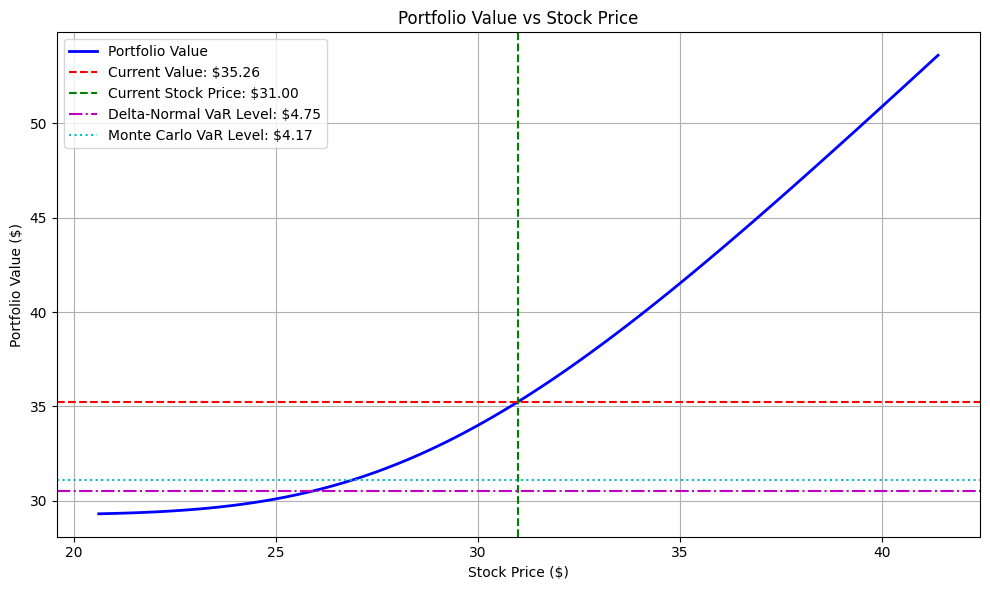

In [17]:
def plot_portfolio_value(S, X, T, r, sigma, var_delta_normal, var_mc):
    portfolio_value = gbsm(True, S, X, T, r, b, sigma) + gbsm(False, S, X, T, r, b, sigma) + S
    stock_range = np.linspace(S * (1 - implied_vol), S * (1+ implied_vol), 100)
    
    call_values = np.array([gbsm(True, price, X, T, r, b, sigma) for price in stock_range])
    put_values = np.array([gbsm(False, price, X, T, r, b, sigma) for price in stock_range])
    
    portfolio_values = call_values + put_values + stock_range
    
    plt.figure(figsize=(10, 6))
    plt.plot(stock_range, portfolio_values, 'b-', linewidth=2, label='Portfolio Value')
    
    plt.axhline(y=portfolio_value, color='r', linestyle='--', label=f'Current Value: ${portfolio_value:.2f}')
    
    plt.axvline(x=S, color='g', linestyle='--', label=f'Current Stock Price: ${S:.2f}')
    
    var_line = portfolio_value - var_delta_normal
    plt.axhline(y=var_line, color='m', linestyle='-.', label=f'Delta-Normal VaR Level: ${var_delta_normal:.2f}')
    
    var_mc_line = portfolio_value - var_mc
    plt.axhline(y=var_mc_line, color='c', linestyle=':', label=f'Monte Carlo VaR Level: ${var_mc:.2f}')
    
    plt.title('Portfolio Value vs Stock Price')
    plt.xlabel('Stock Price ($)')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()

initial_portfolio_value = initial_call_price + initial_put_price + S
plot_portfolio_value(S, X, T, r, implied_vol, var_delta_normal, var_mc)